# Predicting Home Prices in Bengaluru
Dataset is downloaded from here: https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

## Importing libraries

In [259]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams["figure.figsize"]= (20,10)

In [260]:
import warnings
warnings.filterwarnings("ignore")

## Data Load: Load bengaluru home prices into a dataframe

In [261]:
df1=pd.read_csv("Bengaluru_House_Data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [262]:
df1.shape

(13320, 9)

In [263]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [264]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [265]:
df1['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

In [266]:
df1.dtypes

area_type        object
availability     object
location         object
size             object
society          object
total_sqft       object
bath            float64
balcony         float64
price           float64
dtype: object

In [267]:
df1['society'].isnull().value_counts()

False    7818
True     5502
Name: society, dtype: int64

### Drop features that are not required to build our model

In [268]:
df2 = df1.drop(['society','availability'],axis='columns')
df2.shape

(13320, 7)

In [269]:
df2.head()

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Super built-up Area,Kothanur,2 BHK,1200,2.0,1.0,51.00


## Data Cleaning: Handle NA values

In [270]:
df2.isnull().sum()

area_type       0
location        1
size           16
total_sqft      0
bath           73
balcony       609
price           0
dtype: int64

In [271]:
df2.shape

(13320, 7)

In [272]:
df3 = df2.dropna()
df3.isnull().sum()

area_type     0
location      0
size          0
total_sqft    0
bath          0
balcony       0
price         0
dtype: int64

In [273]:
df3.shape

(12710, 7)

## Feature Engineering
**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [274]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

array([ 2,  4,  3,  1,  6,  8,  7,  5, 11,  9, 27, 43, 14, 12, 10, 13],
      dtype=int64)

## Explore total_sqft feature

In [275]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [276]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,area_type,location,size,total_sqft,bath,balcony,price,bhk
30,Super built-up Area,Yelahanka,4 BHK,2100 - 2850,4.0,0.0,186.000,4
122,Super built-up Area,Hebbal,4 BHK,3067 - 8156,4.0,0.0,477.000,4
137,Super built-up Area,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,0.0,54.005,2
165,Super built-up Area,Sarjapur,2 BHK,1145 - 1340,2.0,0.0,43.490,2
188,Super built-up Area,KR Puram,2 BHK,1015 - 1540,2.0,0.0,56.800,2
410,Super built-up Area,Kengeri,1 BHK,34.46Sq. Meter,1.0,0.0,18.500,1
549,Super built-up Area,Hennur Road,2 BHK,1195 - 1440,2.0,0.0,63.770,2
661,Super built-up Area,Yelahanka,2 BHK,1120 - 1145,2.0,0.0,48.130,2
672,Built-up Area,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,0.0,445.000,4
772,Super built-up Area,Banashankari Stage VI,2 BHK,1160 - 1195,2.0,0.0,59.935,2


In [277]:
df3.dtypes

area_type      object
location       object
size           object
total_sqft     object
bath          float64
balcony       float64
price         float64
bhk             int64
dtype: object

**Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases**

In [278]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [279]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(10)

,area_type,location,size,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4
2,Built-up Area,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3
4,Super built-up Area,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2
5,Super built-up Area,Whitefield,2 BHK,1170.0,2.0,1.0,38.00,2
8,Super built-up Area,Marathahalli,3 BHK,1310.0,3.0,1.0,63.25,3
10,Super built-up Area,Whitefield,3 BHK,1800.0,2.0,2.0,70.00,3
11,Plot Area,Whitefield,4 Bedroom,2785.0,5.0,3.0,295.00,4
12,Super built-up Area,7th Phase JP Nagar,2 BHK,1000.0,2.0,1.0,38.00,2


## Feature Engineering
**Add new feature called price per square feet**

In [280]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,area_type,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Super built-up Area,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,3699.810606
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4,4615.384615
2,Built-up Area,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3,4305.555556
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3,6245.890861
4,Super built-up Area,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2,4250.000000


In [281]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.266800e+04
mean     6.876277e+03
std      2.263354e+04
min      2.678298e+02
25%      4.242721e+03
50%      5.376344e+03
75%      7.142857e+03
max      2.300000e+06
Name: price_per_sqft, dtype: float64

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [282]:
df5['location'].value_counts(ascending=False)

Whitefield                            513
Sarjapur  Road                        372
Electronic City                       300
Kanakpura Road                        259
Thanisandra                           230
                                     ... 
6th Block Jayanagar                     1
Kengeri Satellite Town ( BDA SITE)      1
Wheelers Road                           1
PNS Layout                              1
Jayanagar,                              1
Name: location, Length: 1259, dtype: int64

In [283]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

Whitefield                    514
Sarjapur  Road                372
Electronic City               302
Kanakpura Road                259
Thanisandra                   233
                             ... 
JP Nagar 8th Phase,             1
Chellikere                      1
BTM Layout 1stage 9th Main      1
Tilak Nagar                     1
Rainbow Drive                   1
Name: location, Length: 1248, dtype: int64

In [284]:
location_stats.values.sum()

12668

In [285]:
len(location_stats[location_stats>10])

235

## Dimensionality Reduction
**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [286]:
location_stats_less_than_10 = location_stats[location_stats<=10]
len(location_stats_less_than_10)

1013

In [287]:
len(df5.location.unique())

1248

In [288]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

236

In [289]:
df5.head(10)

,area_type,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Super built-up Area,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,3699.810606
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4,4615.384615
2,Built-up Area,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3,4305.555556
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3,6245.890861
4,Super built-up Area,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2,4250.000000
5,Super built-up Area,Whitefield,2 BHK,1170.0,2.0,1.0,38.00,2,3247.863248
8,Super built-up Area,Marathahalli,3 BHK,1310.0,3.0,1.0,63.25,3,4828.244275
10,Super built-up Area,Whitefield,3 BHK,1800.0,2.0,2.0,70.00,3,3888.888889
11,Plot Area,Whitefield,4 Bedroom,2785.0,5.0,3.0,295.00,4,10592.459605
12,Super built-up Area,7th Phase JP Nagar,2 BHK,1000.0,2.0,1.0,38.00,2,3800.000000


## Outlier Removal Using Business Logic

**According to a real estate expert, normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If we have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [290]:
df5[df5.total_sqft/df5.bhk<300].head(10)

,area_type,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
58,Plot Area,Murugeshpalya,6 Bedroom,1407.0,4.0,1.0,150.0,6,10660.980810
68,Plot Area,Devarachikkanahalli,8 Bedroom,1350.0,7.0,0.0,85.0,8,6296.296296
70,Plot Area,other,3 Bedroom,500.0,3.0,2.0,100.0,3,20000.000000
78,Built-up Area,Kaval Byrasandra,2 BHK,460.0,1.0,0.0,22.0,2,4782.608696
89,Plot Area,Rajaji Nagar,6 Bedroom,710.0,6.0,3.0,160.0,6,22535.211268
119,Plot Area,Hennur Road,2 Bedroom,276.0,3.0,3.0,23.0,2,8333.333333
129,Plot Area,Vishwapriya Layout,7 Bedroom,950.0,7.0,0.0,115.0,7,12105.263158
170,Super built-up Area,other,6 BHK,1300.0,6.0,0.0,99.0,6,7615.384615
176,Plot Area,Kumaraswami Layout,5 Bedroom,600.0,3.0,2.0,85.0,5,14166.666667
193,Plot Area,other,7 Bedroom,1800.0,7.0,1.0,250.0,7,13888.888889


**Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely**

In [291]:
df5.shape

(12668, 9)

In [292]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12013, 9)

# Outlier Removal Using Standard Deviation and Mean

In [293]:
df6.price_per_sqft.describe()

count     12013.000000
mean       6206.082347
std        3985.518807
min         267.829813
25%        4199.363057
50%        5252.525253
75%        6823.529412
max      176470.588235
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is Rs 267 /sqft whereas max is 176470, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [294]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(9852, 9)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

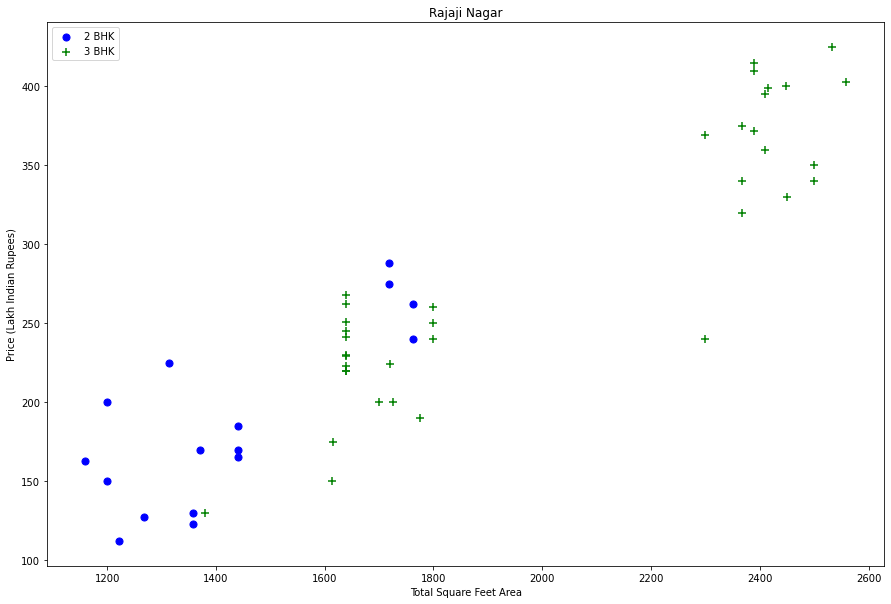

In [295]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

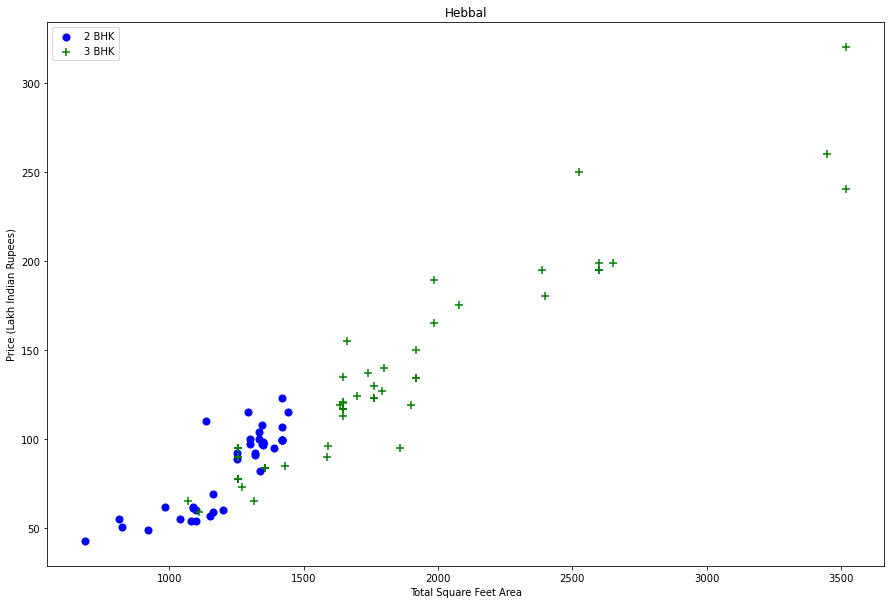

In [296]:
plot_scatter_chart(df7,"Hebbal")

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**

    {
        '1' : {
            'mean': 4000,
            'std: 2000,
            'count': 34
        },
        '2' : {
            'mean': 4300,
            'std: 2300,
            'count': 22
        },    
    }
**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [297]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7014, 9)

**Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties**

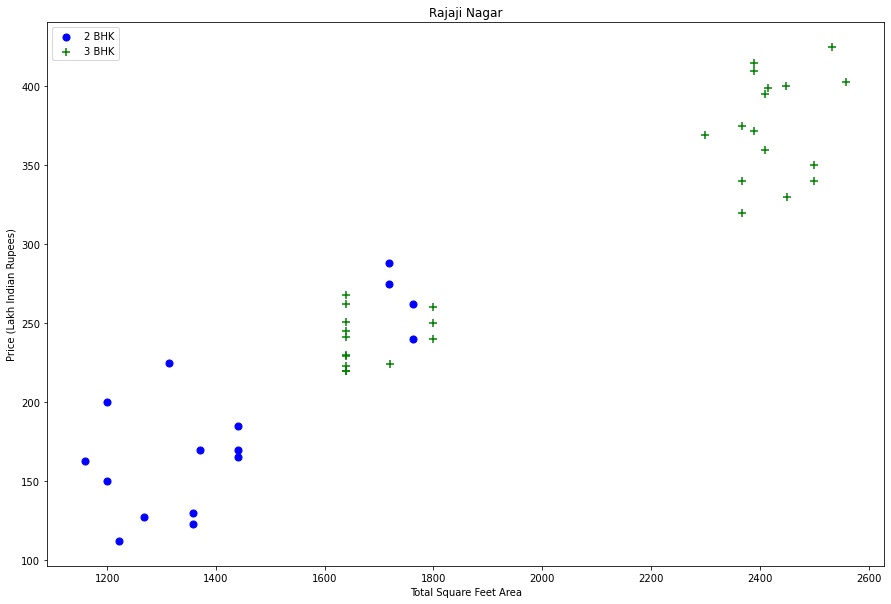

In [298]:
plot_scatter_chart(df8,"Rajaji Nagar")

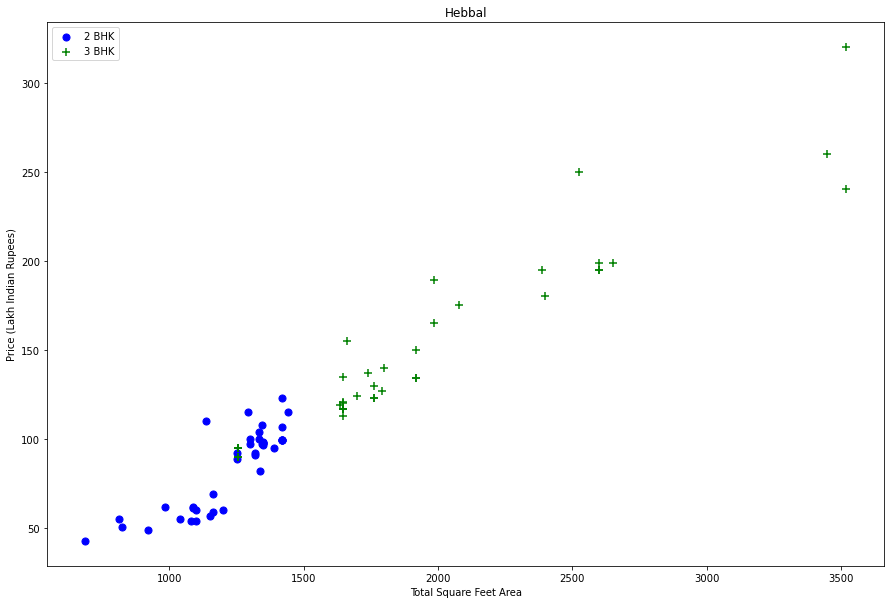

In [299]:
plot_scatter_chart(df8,"Hebbal")

Text(0, 0.5, 'Count')

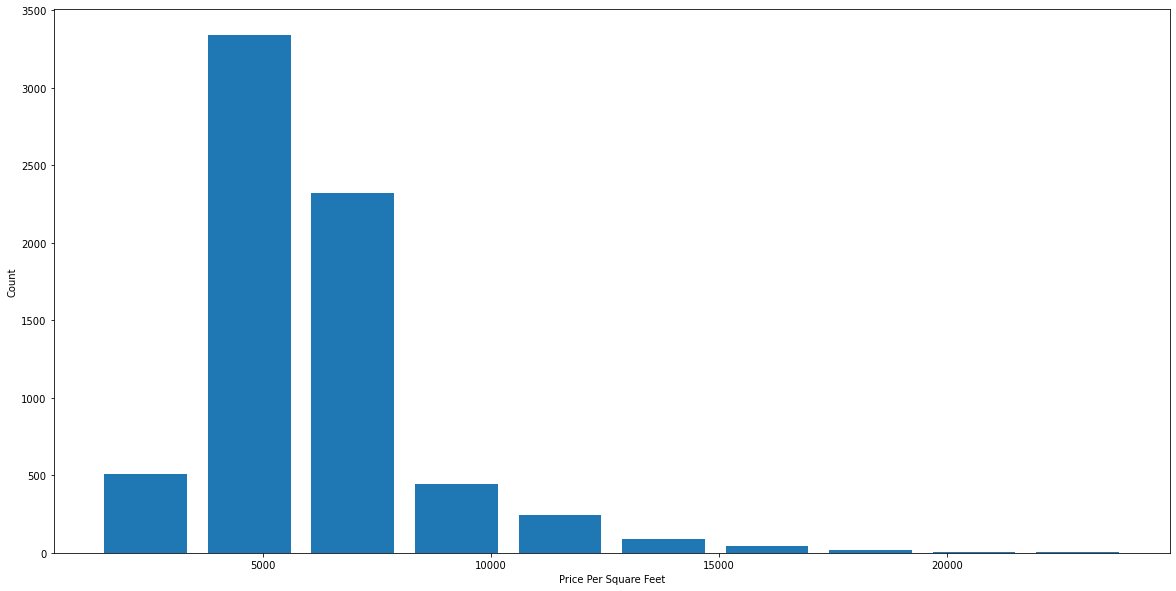

In [300]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [301]:
df8[df8.bath>df8.bhk].head()

,area_type,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
9,Super built-up Area,1st Phase JP Nagar,3 BHK,2065.0,4.0,1.0,210.0,3,10169.491525
14,Built-up Area,1st Phase JP Nagar,1 BHK,840.0,2.0,2.0,50.0,1,5952.380952
33,Plot Area,2nd Stage Nagarbhavi,6 Bedroom,3000.0,8.0,3.0,451.0,6,15033.333333
34,Plot Area,2nd Stage Nagarbhavi,6 Bedroom,2400.0,8.0,3.0,450.0,6,18750.000000
39,Built-up Area,5th Phase JP Nagar,2 BHK,1150.0,3.0,3.0,52.5,2,4565.217391


In [302]:
df8[df8.bath>df8.bhk+1]

,area_type,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
33,Plot Area,2nd Stage Nagarbhavi,6 Bedroom,3000.0,8.0,3.0,451.0,6,15033.333333
34,Plot Area,2nd Stage Nagarbhavi,6 Bedroom,2400.0,8.0,3.0,450.0,6,18750.000000
506,Super built-up Area,Arekere,4 BHK,2710.0,6.0,2.0,142.0,4,5239.852399
553,Plot Area,BTM 2nd Stage,3 Bedroom,1260.0,5.0,1.0,185.0,3,14682.539683
785,Super built-up Area,Bannerghatta,4 BHK,3012.0,6.0,2.0,250.0,4,8300.132802
...,...,...,...,...,...,...,...,...,...
9538,Super built-up Area,other,4 BHK,6652.0,6.0,1.0,510.0,4,7666.867108
9656,Super built-up Area,other,2 BHK,600.0,4.0,1.0,70.0,2,11666.666667
9708,Plot Area,other,3 Bedroom,5656.0,5.0,0.0,499.0,3,8822.489392
9815,Super built-up Area,other,4 BHK,6652.0,6.0,1.0,660.0,4,9921.828022


In [303]:
df8[df8.bath>df8.bhk+2]

,area_type,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
1542,Built-up Area,Chikkabanavar,4 Bedroom,2460.0,7.0,2.0,80.0,4,3252.032520
6443,Super built-up Area,Thanisandra,3 BHK,1806.0,6.0,2.0,116.0,3,6423.034330
8082,Super built-up Area,other,6 BHK,11338.0,9.0,1.0,1000.0,6,8819.897689


**In 4 BHK flat, if we have bathroom in all 4 rooms plus one guest bathroom, we will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [304]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(6947, 9)

In [305]:
df9.head(2)

,area_type,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Super built-up Area,1st Block Jayanagar,4 BHK,2850.0,4.0,1.0,428.0,4,15017.543860
1,Super built-up Area,1st Block Jayanagar,3 BHK,1630.0,3.0,2.0,194.0,3,11901.840491


In [306]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,area_type,location,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,1st Block Jayanagar,2850.0,4.0,1.0,428.0,4
1,Super built-up Area,1st Block Jayanagar,1630.0,3.0,2.0,194.0,3
2,Super built-up Area,1st Block Jayanagar,1875.0,2.0,3.0,235.0,3


# Use One Hot Encoding For area_type & location

In [307]:
dummies_at = pd.get_dummies(df10.area_type)
dummies_at.head()

,Built-up Area,Carpet Area,Plot Area,Super built-up Area
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,1,0,0,0
4,0,0,0,1


In [308]:
dummies_loc = pd.get_dummies(df10.location)
dummies_loc.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [309]:
df11 = pd.concat([df10,dummies_at],axis='columns')
df11.head()

,area_type,location,total_sqft,bath,balcony,price,bhk,Built-up Area,Carpet Area,Plot Area,Super built-up Area
0,Super built-up Area,1st Block Jayanagar,2850.0,4.0,1.0,428.0,4,0,0,0,1
1,Super built-up Area,1st Block Jayanagar,1630.0,3.0,2.0,194.0,3,0,0,0,1
2,Super built-up Area,1st Block Jayanagar,1875.0,2.0,3.0,235.0,3,0,0,0,1
3,Built-up Area,1st Block Jayanagar,1200.0,2.0,0.0,130.0,3,1,0,0,0
4,Super built-up Area,1st Block Jayanagar,1235.0,2.0,2.0,148.0,2,0,0,0,1


In [310]:
df11 = pd.concat([df10,dummies_loc.drop('other',axis='columns')],axis='columns')
df11.head()

,area_type,location,total_sqft,bath,balcony,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,Super built-up Area,1st Block Jayanagar,2850.0,4.0,1.0,428.0,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Super built-up Area,1st Block Jayanagar,1630.0,3.0,2.0,194.0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Super built-up Area,1st Block Jayanagar,1875.0,2.0,3.0,235.0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Built-up Area,1st Block Jayanagar,1200.0,2.0,0.0,130.0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Super built-up Area,1st Block Jayanagar,1235.0,2.0,2.0,148.0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [311]:
df12 = df11.drop(['area_type', 'location'],axis='columns')
df12.head()

,total_sqft,bath,balcony,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,1.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,2.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,0.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Model Building

In [312]:
df12.shape

(6947, 240)

In [313]:
X = df12.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,balcony,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,1.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,2.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [314]:
X.shape

(6947, 239)

In [315]:
y = df12.price
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [316]:
len(y)

6947

In [317]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=10)

In [318]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8588667416904567

**Use K Fold cross validation to measure accuracy of our LinearRegression model**

In [319]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.86797621, 0.8541912 , 0.83637616, 0.87769117, 0.78937901])

**We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose**

# Find best model using GridSearchCV

In [320]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2,3,4,5],
                'selection': ['random', 'cyclic']
            }
        },
        'ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [1,2,3,4,5],
                'normalize': [True, False]
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.845123,{'normalize': True}
1,lasso,0.683873,"{'alpha': 1, 'selection': 'random'}"
2,ridge,0.843409,"{'alpha': 1, 'normalize': False}"
3,decision_tree,0.641215,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


**Based on above results we can say that LinearRegression gives the best score. Hence we will use that.**

# Test the model for few properties

In [321]:
def predict_price(area_type,location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [322]:
predict_price('Built-up Area','1st Phase JP Nagar',1000, 2, 2)

92.71635085336908

In [323]:
predict_price('Built-up Area','1st Phase JP Nagar',1000, 3, 3)

92.80564441263823

In [324]:
predict_price('Built-up Area','Indira Nagar',1000, 2, 2)

153.344526374419

In [325]:
predict_price('Super built-up Area','Indira Nagar',1000, 3, 3)

153.43381993368814